In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_narrow_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [3]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [4]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=1, sigma=1)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=1, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=.3)
    beta_H = pm.Normal("beta_H", mu=3, sigma=1)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = pm.Normal("beta_H2", mu=3, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = pm.Normal("alpha_L", mu=10, sigma=3)
    alpha_1 = pm.Normal("alpha_1", mu=10, sigma=3)
    alpha_2 = pm.Normal("alpha_2", mu=1, sigma=3)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)

    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [5]:
error_mean

0.029386152798353913

In [6]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(3000, tune=2000, chains=4) # chains=6 would still use 4 cores

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 1132 seconds.
There were 2780 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 888kB
 Dimensions:  (chain: 4, draw: 3000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 24kB 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
 Data variables:
     alpha_1  (chain, draw) float64 96kB 9.627 6.856 6.118 ... 15.31 9.19 13.79
     alpha_2  (chain, draw) float64 96kB -0.6231 -0.8518 -0.9489 ... -2.999 -3.0
     alpha_L  (chain, draw) float64 96kB 41.21 40.65 40.19 ... 19.46 18.83 12.88
     beta_H   (chain, draw) float64 96kB 1.017 0.9769 0.9752 ... 1.344 1.31 1.292
     beta_H2  (chain, draw) float64 96kB 4.979 4.313 4.394 ... 0.03085 0.03142
     beta_L   (chain, draw) float64 96kB 0.4175 0.4317 0.4337 ... 1.434 1.354
     eta      (chain, draw) float64 96kB 0.3983 0.1621 0.1546 ... 0.01666 0.01622
     rho      (chain, draw) float64 96kB 0.431 1.017 1.072 ... 1.104e+03 801.7
     sigma    (chain, draw) float64 96kB 0.09001 0.09066 ... 0.08312 0.08079
 Attributes:
     created_at:                 2024

In [8]:
idata.posterior.data_vars

Data variables:
    alpha_1  (chain, draw) float64 96kB 9.627 6.856 6.118 ... 15.31 9.19 13.79
    alpha_2  (chain, draw) float64 96kB -0.6231 -0.8518 -0.9489 ... -2.999 -3.0
    alpha_L  (chain, draw) float64 96kB 41.21 40.65 40.19 ... 19.46 18.83 12.88
    beta_H   (chain, draw) float64 96kB 1.017 0.9769 0.9752 ... 1.344 1.31 1.292
    beta_H2  (chain, draw) float64 96kB 4.979 4.313 4.394 ... 0.03085 0.03142
    beta_L   (chain, draw) float64 96kB 0.4175 0.4317 0.4337 ... 1.434 1.354
    eta      (chain, draw) float64 96kB 0.3983 0.1621 0.1546 ... 0.01666 0.01622
    rho      (chain, draw) float64 96kB 0.431 1.017 1.072 ... 1.104e+03 801.7
    sigma    (chain, draw) float64 96kB 0.09001 0.09066 ... 0.08312 0.08079

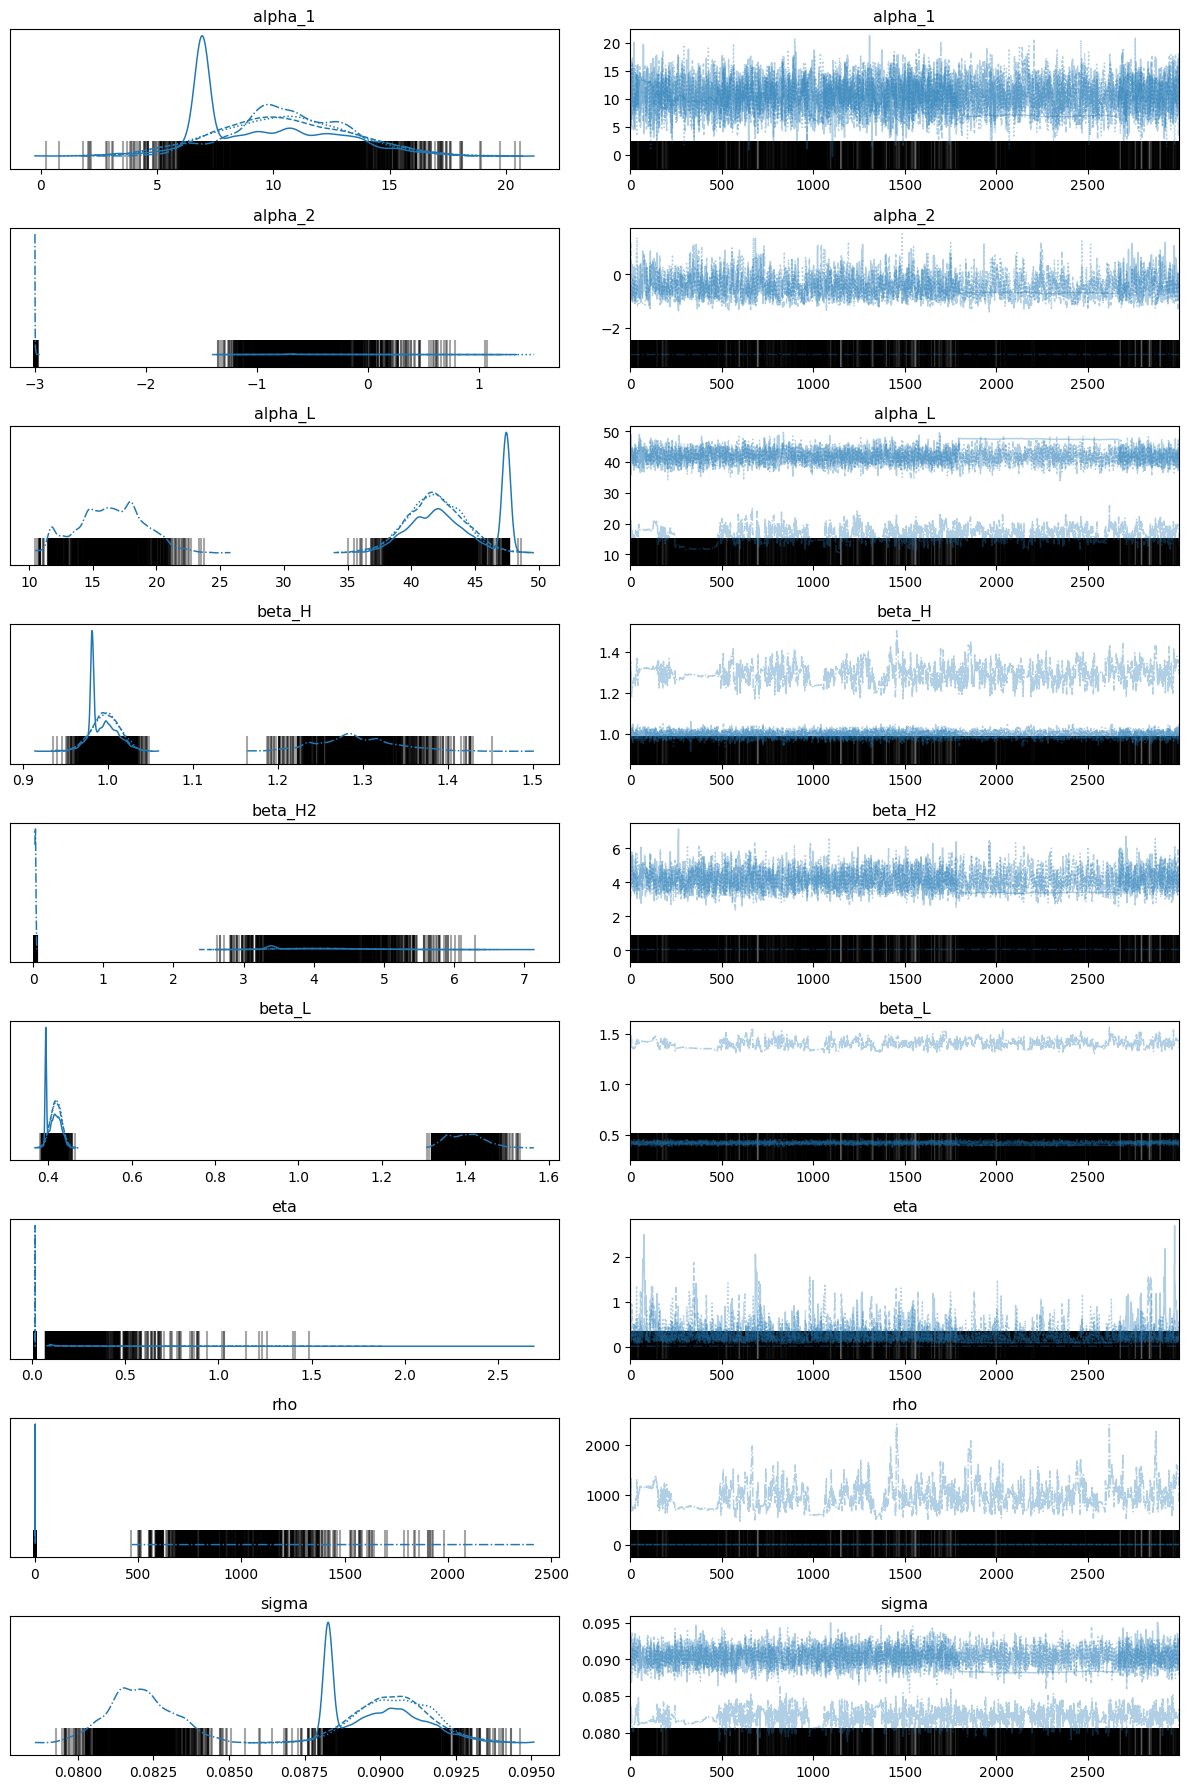

In [9]:
az.plot_trace(idata)
plt.tight_layout()

In [10]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[0.01680909 0.14875237 0.36241164]
[4.45309229e-01 1.08894110e+00 8.21756573e+02]
[0.40282792 0.42308509 1.38320587]
[0.98138419 1.00302648 1.2762456 ]


In [11]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1,10.266,2.904,5.440,15.966,0.333,0.237,79.121,4195.440,1.037
alpha_2,-1.112,1.145,-3.000,0.149,0.546,0.437,7.029,19.475,1.667
alpha_L,35.910,11.539,14.522,47.628,5.645,4.309,6.273,19.189,1.704
beta_H,1.070,0.131,0.959,1.329,0.064,0.049,6.915,28.571,1.561
beta_H2,3.071,1.834,0.026,5.023,0.882,0.671,6.780,19.730,1.590
beta_L,0.662,0.428,0.385,1.435,0.213,0.163,6.501,30.908,1.646
eta,0.210,0.230,0.016,0.599,0.058,0.042,6.808,23.529,1.590
rho,241.349,437.441,0.061,1131.615,208.545,158.520,6.944,31.142,1.568
sigma,0.088,0.004,0.081,0.093,0.002,0.001,6.722,28.361,1.597


In [12]:
posterior_eta.values.flatten()

array([0.39833688, 0.16209606, 0.15463826, ..., 0.01659039, 0.01666278,
       0.01621884])

In [13]:
# Alternative method to find mode using histogram
def get_histogram_mode(data, bins=500):
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mode = bin_centers[np.argmax(hist)]
    return mode

# Extracting modes using histogram method for comparison
hist_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_histogram_mode(samples)
    hist_modes[var] = mode

print("Histogram modes of each posterior:")
for var, mode in hist_modes.items():
    print(f"{var}: {mode}")

Histogram modes of each posterior:
alpha_1: 7.015596211827465
alpha_2: -2.9954501747326505
alpha_L: 47.381427175122276
beta_H: 0.9803615441732249
beta_H2: 0.03298594218259786
beta_L: 0.3929736925873333
eta: 0.01846095748714774
rho: 2.4794373757342827
sigma: 0.0883001015552542


In [14]:
from scipy.stats import gaussian_kde

# Assuming `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Function to compute the mode using KDE
def get_mode_kde(data):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    mode = x_grid[np.argmax(kde(x_grid))]
    return mode

# Extracting modes for each parameter using KDE
kde_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_mode_kde(samples)
    kde_modes[var] = mode

print("KDE modes of each posterior:")
for var, mode in kde_modes.items():
    print(f"{var}: {mode}")


KDE modes of each posterior:
alpha_1: 10.164013129402244
alpha_2: -0.649021578290998
alpha_L: 41.81514686043459
beta_H: 0.9951420959286323
beta_H2: 3.9005802805987004
beta_L: 0.4157667964488828
eta: 0.021144075006494588
rho: 0.06104366992331805
sigma: 0.09040903947328821


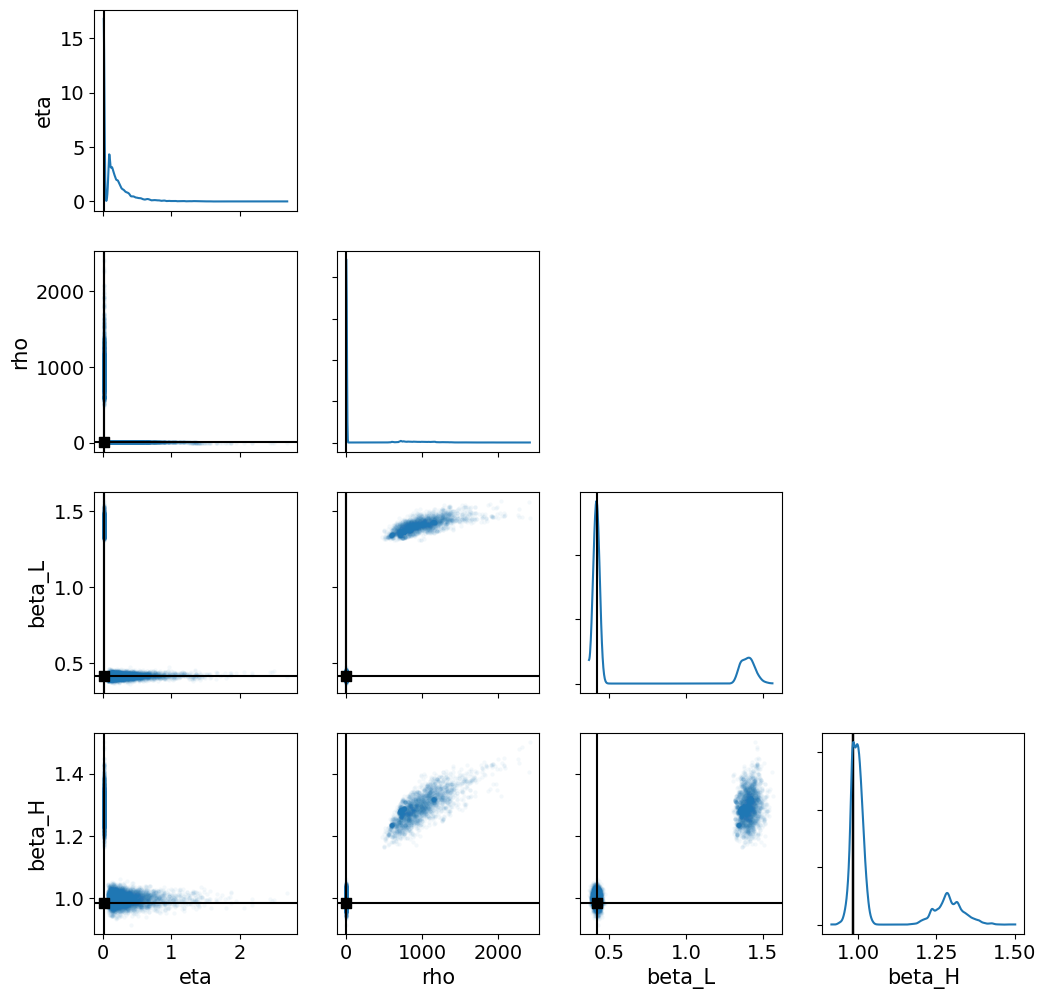

In [15]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="mode",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [16]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import arviz as az  # Assume idata is an ArviZ InferenceData object

# Assume `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Define a function to evaluate the joint density using KDE
def joint_kde_density(point, samples):
    kde = gaussian_kde(samples.T)  # Transpose for proper shape
    return -kde(point)  # Negative because we are minimizing

# Extract the samples of all four parameters of interest
param_names = ['rho', 'eta', 'beta_L', 'beta_H', 'beta_H2', 'alpha_L', 'alpha_1', 'alpha_2', 'sigma']  # Replace with actual parameter names
sample_arrays = [posterior_samples[param].values.flatten() for param in param_names]

# Combine samples into a 2D array for joint distribution
joint_samples = np.vstack(sample_arrays).T

# Initial guess for the optimizer (mean of samples can be a good starting point)
initial_guess = np.mean(joint_samples, axis=0)

# Perform the optimization to find the mode
result = minimize(joint_kde_density, initial_guess, args=(joint_samples,), method='L-BFGS-B')

# The result contains the mode of the joint distribution
global_mode = result.x

# Print the global mode of the joint distribution
print(f"Global mode of the joint distribution ({', '.join(param_names)}): {global_mode}")

Global mode of the joint distribution (rho, eta, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma): [ 2.41295802e+02  1.33558501e-01  6.43839236e-01  1.06941196e+00
  3.22593421e+00  3.61877241e+01  1.03024036e+01 -1.22119199e+00
  8.83859582e-02]


In [17]:
# define the error function 2 param modes
def error_function(n_LF, n_HF):
    eta = 11.20294568777112
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 34422.595850790254
    beta_L = 1.1406839520015446
    beta_H = 4.145389781446169
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = 2.713544143928366
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = 7.8176404049598816
    alpha_1 = 18.553167013696203
    alpha_2 = 7.5153891398955235

    sigma_lg_Phi = 0.21450697746101002   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [18]:
# loss  mean
lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - np.log(rel_error))**2)

In [19]:
loss

4.823735113713281